<h1 align='center'>Utilizing Scientific Python Tools for the Application of Data Science Techniques to High Impact Weather Prediction</h1>
<h2 align='center'>David John Gagne II<br />University of Oklahoma/National Center for Atmospheric Research</h2>
<h4 align='center'>April 13, 2015<br />2015 UCAR SEA Conference</h4>
<h5 align='center'>Twitter: @DJGagneDos<br>Github: https://www.github.com/djgagne</h5>

##Acknowledgements
* OU Advisor: Amy McGovern
* NCAR Advisors: Sue Haupt and John Williams
* Severe Hail Analysis, Representation and Prediction (SHARP) Team: Nate Snook, Youngsun Jung, Jon Labriola
* Gridded Atmopsheric Forecast System (GRAFS) Team: Seth Linden, Gerry Wiener, Bill Petzke, Jared Lee
* CAPS: Ming Xue, Kevin Thomas, Keith Brewster, Yunheng Wang, Chris Cook
* NOAA: Jimmy Correia, Adam Clark, Michael Coniglio

##<font color='red'>WARNING</font>: Do ~~NOT~~ Try This At Home!
* Goal: Demonstrate the power of Python Data Science tools 
* Provide a sandbox for users to experiment with real weather data 
* Presentation, source code, and data available at https://www.github.com/djgagne/ucar_sea_2015/
* Requires standard Anaconda Python Distribution with netCDF4-python, Basemap, and IPython 3.0
* If you have git installed: `git clone https://github.com/djgagne/ucar_sea_2015.git`
* Otherwise download the zip file: https://github.com/djgagne/ucar_sea_2015/archive/master.zip

## Motivation
* High impact weather includes weather phenomena that cause large personal and/or economic losses

* Includes extreme weather disasters
    * Hurricanes, tornadoes, __hail__, floods

* Also includes "normal" weather events with economic effects
    * __Unforseen partly cloudy day causes unexpected fluctuations in solar power generation__
    * Ill-timed rainstorm delays wheat harvest
    * Mild, dry, weather closes ski resort early

##Python and Data Science in High Impact Weather Prediction
* Bridge the gap from raw numerical weather prediction (NWP) model output and observations to actionable information
    * Compiling historical model runs and observations
    * Pre-processing data
    * Applying statistical learning models to correct output and make derived products
    * Visualizing results

#Interactive Demonstrations
* Hail Size Prediction
    * Locating hail swaths with image processing techniques
* Solar Irradiance Prediction
    * Train statistical learning models to connect NWP model output with pyranometer observations
    * Validate model predictions

##Hail Size Prediction Libraries


In [43]:
# Useful general libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
from matplotlib.colors import ListedColormap
from collections import OrderedDict
# Custom image segmentation libraries
from hail.EnhancedWatershedSegmenter import EnhancedWatershed
from hail.Hysteresis import Hysteresis
from scipy.ndimage import gaussian_filter

## Data: NOAA NSSL Multi-Radar Multi-Sensor Maximum Estimated Size of Hail
* Radar-estimated hail size based on a 3D radar reflectivity mosaic with 1 km grid-spacing

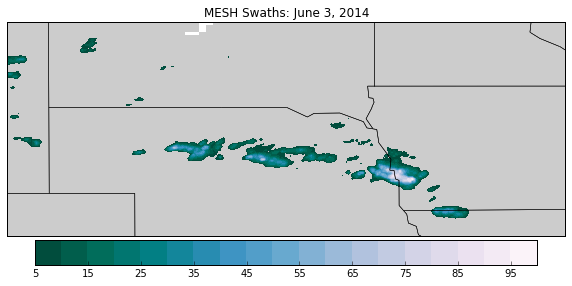

In [3]:
# Load MESH data and plot it
with Dataset("data/MESH_4km_20140603-00:00_20140603-23:00") as mesh_file:
    lon = mesh_file.variables['lon'][:]
    lat = mesh_file.variables['lat'][:]
    mesh_data = mesh_file.variables['MESH'][:]
bmap_hail = Basemap(projection='cyl', resolution='l', 
               llcrnrlon=-105, urcrnrlon=-92,
               llcrnrlat=40, urcrnrlat=45)
plt.figure(figsize=(10,6))
bmap_hail.drawstates()
bmap_hail.drawlsmask()
cont = plt.contourf(lon, lat, mesh_data[22], 
             np.arange(5,105,5), cmap="PuBuGn_r")
cbar = plt.colorbar(orientation="horizontal",shrink=0.9,fraction=0.1, pad=0.01)
title_obj = plt.title("MESH Swaths: June 3, 2014")

##Image Segmentation
* Split image into distinct regions or objects based on intensity values
* Thresholding: objects are contiguous areas with intensities above a specified threshold
* Hysteresis: contiguous areas above a threshold containing at least 1 point above a second threshold
* Watershed: objects are "grown" from local maxima in layers until a minimum intensity is met
* Enhanced Watershed (Lakshmanan et al. 2009): Adds size criteria, buffer regions around objects, and other enhancements

## Image Segmentation Process

In [46]:
from skimage.measure import regionprops
#Hysteresis (low threshold, high threshold)
hyst = Hysteresis(5,25)
# Enhanced Watershed (low threshold, 
#                     discretization interval, 
#                     discretization maximum,
#                     size threshold,
#                     number of watershed iterations)
ew = EnhancedWatershed(5,5,100,200,20)
labels = OrderedDict()
labels['Hysteresis'] = hyst.label(gaussian_filter(mesh_data[22], 1))
print "Number of Hysteresis Objects:", labels['Hysteresis'].max()
labels['Enhanced Watershed'] = ew.label(gaussian_filter(mesh_data[22],1))
print "Number of Enhanced Watershed Objects:", labels['Enhanced Watershed'].max()
labels['Enhanced Watershed Size Filter'] = ew.size_filter(labels['Enhanced Watershed'], 30)
print "Number of Size Filtered Objects:", labels['Enhanced Watershed Size Filter'].max()


Number of Hysteresis Objects: 5
Number of Enhanced Watershed Objects: 28
Number of Size Filtered Objects: 10


## Image Segmentation Examples

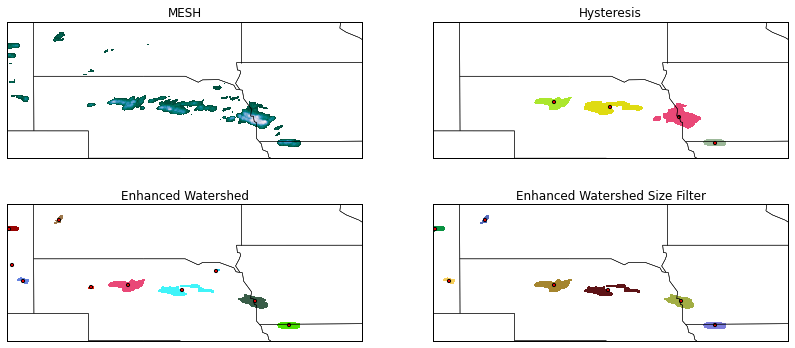

In [54]:
# Plot objects
cm = ListedColormap(np.random.random((50,3)))
plt.figure(figsize=(14,6))
plt.subplot(2,2,1)
bmap_hail.drawstates()
plt.title("MESH")
cont = plt.contourf(lon, lat, mesh_data[22], 
             np.arange(5,105,5), cmap="PuBuGn_r")
sp = 2
for plot_name, image in labels.iteritems():
    plt.subplot(2,2,sp)
    bmap_hail.drawstates()
    ht = plt.title(plot_name)
    pcol = plt.contourf(lon, lat, np.ma.array(image, mask=image < 1), 
                      np.arange(image.max() + 1), cmap=cm)
    props = regionprops(image)
    centroids = np.round([prop.centroid for prop in props]).astype(int)
    plt.scatter(lon[centroids[:,0],centroids[:,1]],
                lat[centroids[:,0],centroids[:,1]], 10, 'r')
    sp += 1

##Hysteresis vs. Enhanced Watershed
* Hysteresis
    1. Only 2 parameters to set
    2. Captures entirety of regions
    3. Can combine seemingly distinct objects
* Enhanced Watershed
    1. Captures different scales depending on size threshold
    2. Captures core of objects
    3. Can separate even adjacent objects

##Solar Irradiance Prediction
* Solar power is providing a rapidly growing share of the electricity generated worldwide
* Electric grids are more vulnerable to irregular fluxations in solar energy generation
* Improved forecasting of solar irradiance leads to fewer surprises, cheaper solar energy
* Best forecasting methods combine NWP output with a statistical learning model

##Loading Data
* NWP Output comes from NAM; observations are pyranometers from MADIS network
* Pandas library can be used to read csv files quickly and import data into a Data Frame

In [86]:
solar_training_data = pd.read_csv("data/grafs_train_data.csv")
solar_testing_data = pd.read_csv("data/grafs_test_data.csv")
for col in solar_training_data.columns:
    print col 

station
date
valid_hour_utc
valid_hour_pst
forecast_hour
day_of_year
sine_doy
row
col
asp
dem
slope
T_f
T_f_mean
T_f_max
T_f_min
T_f_median
T_f_correlate
T_f_gradient
av_dswrf_sfc_f
av_dswrf_sfc_f_mean
av_dswrf_sfc_f_max
av_dswrf_sfc_f_min
av_dswrf_sfc_f_median
av_dswrf_sfc_f_correlate
av_dswrf_sfc_f_gradient
cloud_cover_f
cloud_cover_f_mean
cloud_cover_f_max
cloud_cover_f_min
cloud_cover_f_median
cloud_cover_f_correlate
cloud_cover_f_gradient
dewpt_f
dewpt_f_mean
dewpt_f_max
dewpt_f_min
dewpt_f_median
dewpt_f_correlate
dewpt_f_gradient
index
av_dswrf_sfc
lat
lon
add_diff


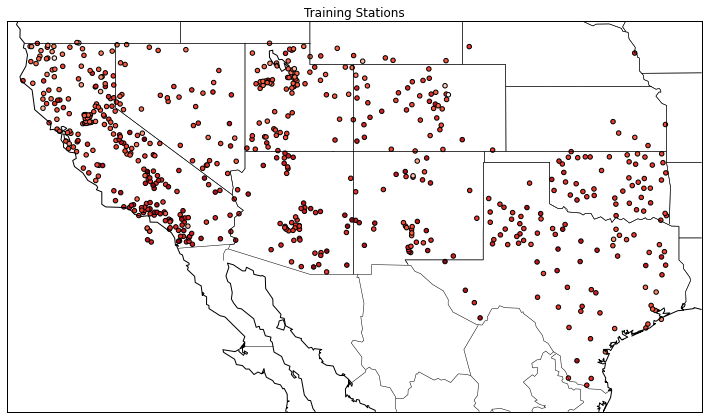

In [84]:
train_stations = solar_training_data['station'].unique()
max_solar = np.zeros(train_stations.size)
station_lats = np.zeros(train_stations.size)
station_lons = np.zeros(train_stations.size)
for ts, train_station in enumerate(train_stations):
    is_station = solar_training_data['station'] == train_station
    station_idxs = np.nonzero(is_station)[0]
    max_solar[ts] = solar_training_data['av_dswrf_sfc'][is_station].max()
    station_lons[ts] = solar_training_data['lon'][station_idxs[0]]
    station_lats[ts] = solar_training_data['lat'][station_idxs[0]]
bmap = Basemap(projection='cyl', resolution='l', 
               llcrnrlon=-125, urcrnrlon=-93, llcrnrlat=25, urcrnrlat=43)
plt.figure(figsize=(15,7))
bmap.drawstates()
bmap.drawcoastlines()
bmap.drawcountries()
plt.title("Training Stations")
plt.scatter(station_lons, station_lats, 20,max_solar,cmap=plt.get_cmap('Reds'))


##Statistical (Machine) Learning Models
* Scikit-learn provides a straightforward Python interface to many common statistical learning models

In [89]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
# Linear regression
from sklearn.linear_model import Ridge
ridge = Pipeline([('anova',SelectKBest(f_regression,k=15)),('ridge',Ridge(alpha=1))])
# Random forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, max_features='sqrt', max_depth=6)
# Gradient Boosting Regression Trees
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, loss='lad', max_depth=6)
from sklearn.neighbors import KNeighborsRegressor
knr = Pipeline([('anova',SelectKBest(f_regression,k=15)), 
                ('knn',KNeighborsRegressor(n_neighbors=10, weights='uniform'))])

## Fitting the Models

In [90]:
input_columns = np.array(['valid_hour_pst', 'forecast_hour', 'asp', 'dem', 'slope','lat','lon',
                 'T_f', 'T_f_mean', 'T_f_max', 'T_f_min', 'T_f_median', 'T_f_correlate', 'T_f_gradient',
                 'av_dswrf_sfc_f', 'av_dswrf_sfc_f_mean', 'av_dswrf_sfc_f_max', 'av_dswrf_sfc_f_min', 
                 'av_dswrf_sfc_f_median', 'av_dswrf_sfc_f_correlate', 'av_dswrf_sfc_f_gradient', 
                 'cloud_cover_f', 'cloud_cover_f_mean', 'cloud_cover_f_max', 'cloud_cover_f_min', 
                 'cloud_cover_f_median', 'cloud_cover_f_correlate', 'cloud_cover_f_gradient'])
output_column = 'av_dswrf_sfc'
print "Fitting ridge"
ridge.fit(solar_training_data[input_columns], solar_training_data[output_column])
print "Fitting random forest"
rf.fit(solar_training_data[input_columns], solar_training_data[output_column])
print "Fitting gradient boosted regression"
gbr.fit(solar_training_data[input_columns], solar_training_data[output_column])
print "Fitting KNN"
knr.fit(solar_training_data[input_columns], solar_training_data[output_column])

Fitting ridge
Fitting random forest
Fitting gradient boosted regression
Fitting KNN


Pipeline(steps=[('anova', SelectKBest(k=15, score_func=<function f_regression at 0x159f4b578>)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_neighbors=10, p=2, weights='uniform'))])

## Ranking Input Features
Feature Importance quantifies the average increase in error caused by randomizing the values of an input feature.

In [91]:
rf_var_importance_rankings = np.argsort(rf.feature_importances_)[::-1]
gbr_var_importance_rankings = np.argsort(gbr.feature_importances_)[::-1]
knr_var_names =  knr.steps[0][1].get_support(indices=True)
print "Random Forest".ljust(34) + " Gradient Boosting".ljust(35)
for r, g in zip(rf_var_importance_rankings[:15],gbr_var_importance_rankings[:15]):
    print "{0}: {1:0.3f} | {2}: {3:0.3f}".format(input_columns[r].ljust(25), 
                                 rf.feature_importances_[r],
                                 input_columns[g].ljust(25),
                                 gbr.feature_importances_[g])

Random Forest                      Gradient Boosting                 
av_dswrf_sfc_f_min       : 0.177 | av_dswrf_sfc_f_min       : 0.528
av_dswrf_sfc_f_median    : 0.156 | av_dswrf_sfc_f_max       : 0.159
av_dswrf_sfc_f_correlate : 0.130 | lon                      : 0.049
av_dswrf_sfc_f           : 0.126 | av_dswrf_sfc_f_mean      : 0.036
av_dswrf_sfc_f_mean      : 0.115 | dem                      : 0.032
av_dswrf_sfc_f_max       : 0.110 | valid_hour_pst           : 0.031
forecast_hour            : 0.058 | lat                      : 0.030
valid_hour_pst           : 0.049 | forecast_hour            : 0.030
cloud_cover_f_max        : 0.019 | slope                    : 0.028
cloud_cover_f_mean       : 0.009 | av_dswrf_sfc_f_median    : 0.015
cloud_cover_f_min        : 0.009 | asp                      : 0.011
cloud_cover_f_correlate  : 0.007 | av_dswrf_sfc_f_correlate : 0.009
cloud_cover_f            : 0.006 | av_dswrf_sfc_f_gradient  : 0.007
av_dswrf_sfc_f_gradient  : 0.006 | T_f_gradien

## Comparing Model Error

In [105]:
def mean_absolute_error(forecast, obs):
    return np.mean(np.abs(forecast - obs))

predictions = {}
predictions['Ridge Regression'] = ridge.predict(solar_testing_data[input_columns])
predictions['Random Forest'] = rf.predict(solar_testing_data[input_columns])
predictions['Gradient Boosting'] = gbr.predict(solar_testing_data[input_columns])
predictions['KNR'] = knr.predict(solar_testing_data[input_columns])
for model_name, preds in predictions.iteritems():
    print model_name.ljust(20), mean_absolute_error(preds, solar_testing_data[output_column])
print 'NAM'.ljust(20), mean_absolute_error(solar_testing_data['av_dswrf_sfc_f'], solar_testing_data[output_column])

KNR                  77.7203291217
Ridge Regression     77.9943209315
Random Forest        69.7785959564
Gradient Boosting    66.4142395485
NAM                  73.4753167135


## Visualizing Model Predictions

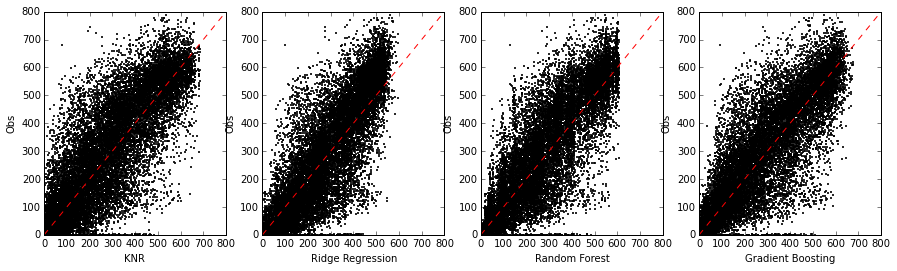

In [93]:
plt.figure(figsize=(15,4))
m = 1
for model_name, preds  in predictions.iteritems():
    plt.subplot(1,len(predictions.keys()),m)
    plt.scatter(predictions[model_name], solar_testing_data[output_column],1,'k')
    plt.plot(np.arange(0,900,100),np.arange(0,900,100),'r--')
    plt.xlim(0,800)
    plt.ylim(0,800)
    plt.xlabel(model_name)
    plt.ylabel("Obs")
    m += 1

##Visualizing Station Error

<matplotlib.colorbar.Colorbar instance at 0x133e365a8>

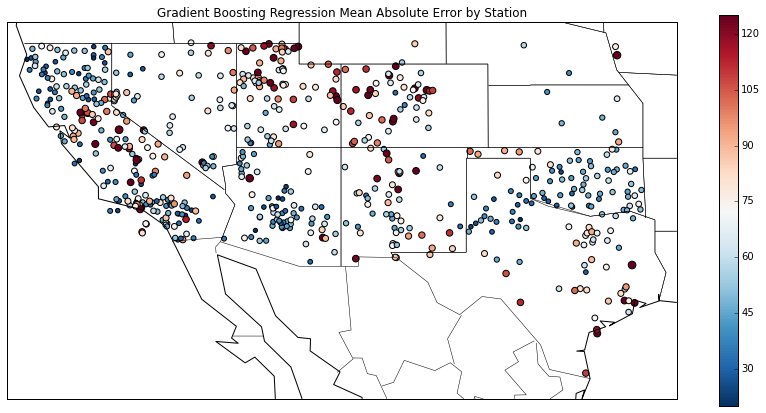

In [94]:
test_stations = solar_testing_data['station'].unique()
station_errors = np.zeros((test_stations.size))
station_lats = np.zeros(test_stations.size)
station_lons = np.zeros(test_stations.size)
for ts, test_station in enumerate(test_stations):
    is_station = solar_testing_data['station'] == test_station
    station_idxs = np.nonzero(is_station)[0]
    station_errors[ts] = mean_absolute_error(predictions['Gradient Boosting'][np.nonzero(is_station)], 
                                             solar_testing_data.loc[is_station,output_column])
    station_lons[ts] = solar_testing_data['lon'][station_idxs[0]]
    station_lats[ts] = solar_testing_data['lat'][station_idxs[0]]
bmap = Basemap(projection='cyl', llcrnrlon=-125, urcrnrlon=-93, llcrnrlat=25, urcrnrlat=43)
plt.figure(figsize=(15,7))
bmap.drawstates()
bmap.drawcoastlines()
bmap.drawcountries()
plt.title("Gradient Boosting Regression Mean Absolute Error by Station")
plt.scatter(station_lons, station_lats, np.sqrt(station_errors) * 4,station_errors,
            vmin=station_errors.min(),
            vmax=np.percentile(station_errors,95),
            cmap='RdBu_r')
plt.colorbar()

## Individual Site Forecasts
* Visualize the time series of forecasts (red) and observations (blue)

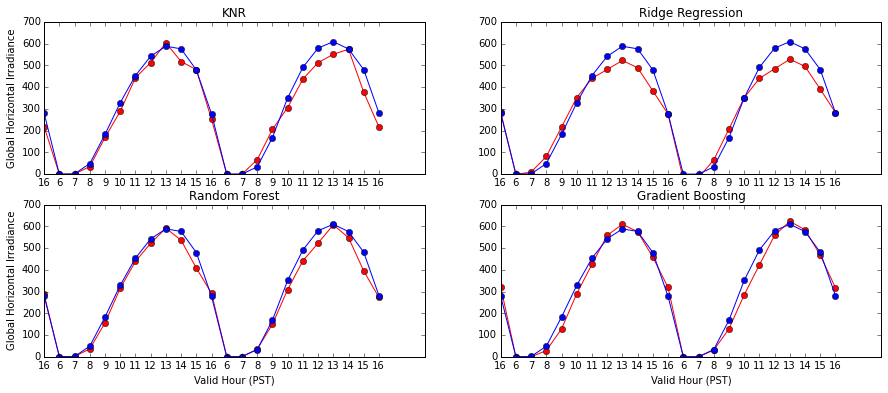

In [102]:
def plot_station_errors(solar_testing_data, predictions, model_name, station_number):
    station_idxs = np.where(solar_testing_data['station']==station_number)[0]
    plt.plot(predictions[station_idxs],'ro-',label=model)
    plt.plot(solar_testing_data[output_column].values[station_idxs],'bo-',label='Obs')
    plt.ylim(0,700)
    plt.xticks(np.arange(len(station_idxs)), solar_testing_data['valid_hour_pst'].values[station_idxs])
    plt.title(model_name)
    
station_number = test_stations[np.argsort(station_errors)][13]
plt.figure(figsize=(15,6))
for m, model in enumerate(predictions.iterkeys()):
    plt.subplot(2, len(predictions.keys()) / 2, m + 1)
    if m % 2 == 0:
        plt.ylabel("Global Horizontal Irradiance")
    plot_station_errors(solar_testing_data, predictions[model], model, station_number)
    if m > 1:
        plt.xlabel("Valid Hour (PST)")

## Summary
* Predicting high impact weather requires interpretation of large amounts of data
* Python and data science tools can ease every step of the data interpretation process
* Presentation, code, and data available at https://www.github.com/djgagne/ucar_sea_2015/
* Please download the presentation and experiment with the data and code
* Questions? **Email**: djgagne@ou.edu    **Twitter**: @DJGagneDos     